In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pandas.read_csv('Files/class_data.csv')
data['label']='data'
data['t_w']=1
data['ltype']=1

In [3]:
def weight_df(df):    
    df['lumiscale'] = df.RunYear.apply(
               lambda x: (36074.6 if (x == 2015 or x == 2016) else 43813.7))
    weights = df.lumiscale*df.pileupEventWeight_090*df.scale_nom*df.JVT_EventWeight*df.MV2c10_70_EventWeight*df.lepSFObjTight*df.lepSFTrigTight*df.SherpaNJetWeight
    return weights


In [4]:
#load MC samples:
def mc_load(labels_list):
    mc_list=[]
    for i in labels_list:
        name='Files/class_mc_'+i+'.csv'
        df=pandas.read_csv(name)
        df['label'] = i
        if i == 'fakes':
            df['t_w'] = 1
        else:
            df['t_w'] = weight_df(df)
        df['ltype']=0
        mc_list.append(df)
        
    mc_df = pandas.concat(mc_list,sort=False)
    return mc_df

In [5]:
def plot_stack_var(df_data,df_bkg,lab_list,var,GeV):
    stack_var=[]
    stack_var_w=[]
    stack_var_leg=[]    
    for i in lab_list:
        stack_var.append(df_bkg[var].loc[df_bkg.label==i]*GeV)
        stack_var_w.append(df_bkg.t_w.loc[df_bkg.label==i])
        stack_var_leg.append(i)

    plt.hist( stack_var, binning[var], histtype='step',
         weights=stack_var_w,
         label=stack_var_leg,
         stacked=True, 
         fill=True, 
         linewidth=2, alpha=0.8)
    plt.hist(df_data[var]*GeV, binning[var], histtype='step',
         label=["data"],
         stacked=False, 
         fill=False, 
         color='k',
         linewidth=2, alpha=0.8)
    plt.xlabel(var,fontsize=12)
    plt.ylabel('# Events',fontsize=12) 
    plt.legend()   

In [6]:
# (best_Z_Mll>0) && abs(lep_ID_0)==abs(lep_ID_1) ) 
#apply additional selections
def apply_3l_Zveto_SF_cuts(df):
    df1=df.loc[abs(df.lep_ID_0)==abs(df.lep_ID_1)]
    df2=df1.loc[df1.best_Z_Mll>0]    
    return df2

In [7]:
scale_to_GeV=0.001
binning = {"DRll01": np.linspace(-2, 6, 24),
           "max_eta": np.linspace(0, 2.5, 26),
           "Mll01": np.linspace(0, 200, 25),
          }
var='Mll01'

In [8]:
labels_list=['ttZ','ttW','ttH','VV','fakes','Others']

In [9]:
bkg_set=mc_load(labels_list)

In [10]:
data_sel=apply_3l_Zveto_SF_cuts(data)
bkg_set_sel=apply_3l_Zveto_SF_cuts(bkg_set)

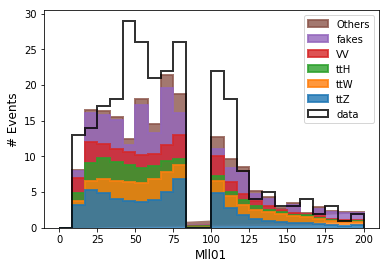

In [11]:
plot_stack_var(data_sel,bkg_set_sel,labels_list,'Mll01',0.001)

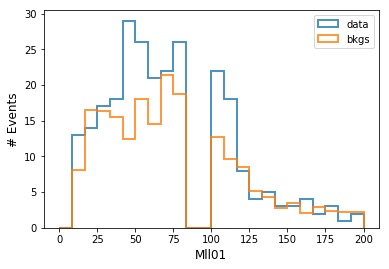

In [12]:
plt.hist(data_sel[var]*scale_to_GeV, binning[var], histtype='step',
         label=["data"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(bkg_set_sel[var]*0.001, binning[var], histtype='step',
         label=["bkgs"],
         weights=bkg_set_sel.t_w,
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.xlabel(var,fontsize=12)
plt.ylabel('# Events',fontsize=12)
#plt.yscale('log')
plt.legend()   

In [13]:
def split_by_Bjet(df):
    df_1b=df.loc[df.nJets_OR_MV2c10_70==1]
    df_2b=df.loc[df.nJets_OR_MV2c10_70>=2]    
    return df_1b,df_2b

In [14]:
def ovr_slot(df_d,df_b,var='Mll01',GeV=0.001,fig_size=(10, 5)):
    f, ax = plt.subplots(figsize=fig_size)
    ax.hist(df_d[var]*GeV, binning[var], histtype='step',
         label=["data"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
    ax.hist(df_b[var]*GeV, binning[var], histtype='step',
         label=["bkgs"],
         weights=df_b.t_w,
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
    ax.set_xlabel(var,fontsize=12)
    ax.set_ylabel('# Events',fontsize=12)    
    ax.legend()   
    return ax


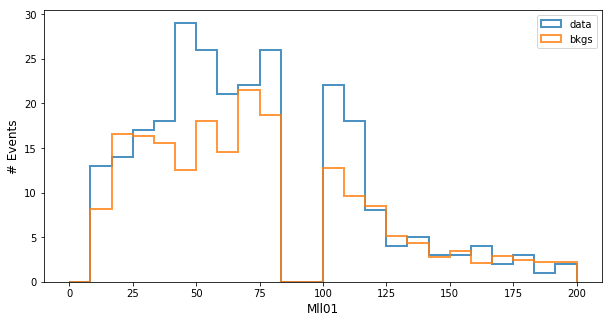

In [15]:
ovr_slot(data_sel,bkg_set_sel)

In [16]:
d_1, d_2 = split_by_Bjet(data_sel)

In [17]:
b_1, b_2 = split_by_Bjet(bkg_set_sel)

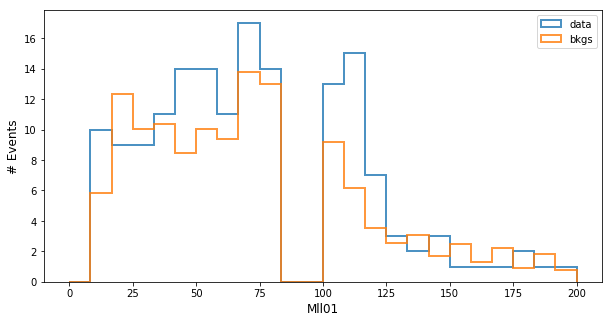

In [18]:
ovr_slot(d_1,b_1)

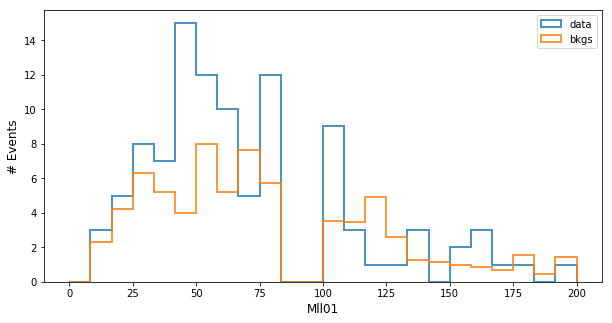

In [19]:
ovr_slot(d_2,b_2)

In [20]:
feature = bkg_set.columns
feature.size

1219

In [21]:
feature[0]
#.str.find('UP')

'entry'

In [ ]:
features

In [23]:
def list_branch_to_remove(df,additional_vars=[]):
    syst_list=['UP','DOWN','CRB','scale','weight','SF','Eff',
               'forFit','HLT','tau','MV2c20','is1','is2','is3','is4',
               'ghost','flvWtOrdr','pass','mc_channel_number','truth',
              'isBrems','isTruth','isQMisID','isExtConv','isConv',
              'isIntConv','isISR','ist','isFake','isLepFromPhEvent',
               'isPrompt','top_','isW','MEphoton','jet_flavor',
              'pileupEventWeight_090','JVT_EventWeight','SherpaNJetWeight','mcWeightOrg','EventWeight',
              'isPrompt','isV','higgs','Clas','bcid','lbn','EventNumber','entry','RunNumber']
    
    syst_list=syst_list+additional_vars
    matches_syst=[]
    features = list(df.columns.values)
    for x in features:
        for j in syst_list:
            if j in x:
                matches_syst.append(x.strip())
    return matches_syst


In [24]:
data_sel_trim = data_sel.drop(list_branch_to_remove(data_sel),axis=1)

In [25]:
bkg_set_sel_trim = bkg_set_sel.drop(list_branch_to_remove(bkg_set_sel),axis=1)

In [27]:
def unify_branches(df_1,df_2):
    s1 = set(df_1.columns)
    list_diff12 = [x for x in df_2.columns if x not in s1]
    df_2m = df_2.drop(list_diff12,axis=1)

    s2 = set(df_2m.columns)
    list_diff21 = [x for x in df_1.columns if x not in s2]
    df_1m = df_1.drop(list_diff21,axis=1)
    #df_1m = df_1                                                                                                                                                                                                                          

    #print(list_diff12,list_diff21)                                                                                                                                                                                                        
    if set(df_1m.columns)==set(df_2m.columns):
        print("All good, content is the same in both classes\n total %s branches" %len(df_1m.columns))
    else:
        print("WARNING: Something went wrong, double check the content")

    return df_1m,df_2m


In [29]:
data_class,bkg_class = unify_branches(data_sel_trim,bkg_set_sel_trim)

All good, content is the same in both classes
 total 483 branches


In [30]:

def test_nans_float32_infs(df):
    out_boundaries = []
    for i in df.columns:
        val = df[i].sum()
        if float(val)>1e+30:
            print("   --- inf or >float32:",i,val)
            out_boundaries.append(i)
        elif df[i].isnull().any():
            print("   --- contain nans:", i)
            out_boundaries.append(i)
    if out_boundaries:
        df.drop(out_boundaries,axis=1, inplace=True)

    return df

In [31]:
def only_unique(df):
    list_same_val_branch = []
    for j in df.columns:
        i0=df[j].sample(1,random_state=0).item()
        if all(i ==i0 for i in df[j]):
            list_same_val_branch.append(j)

    if list_same_val_branch:
        df.drop(list_same_val_branch,axis=1, inplace=True)

    return df

In [32]:

def model_input(df1,df2):
    df1['ltype'] = 1
    df2['ltype'] = 0
    X = pandas.concat([df1,df2], sort=True)
    y = X['ltype']
    X.drop(['ltype','label','t_w'],axis=1, inplace=True)
    X=test_nans_float32_infs(X)
    X=only_unique(X)
    return X,y




In [33]:
X,y=model_input(data_class,bkg_class)

   --- inf or >float32: averageMW 1.879187793375699e+39
   --- contain nans: mlb_h


In [34]:
print(len(X.columns))

332


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler



In [36]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [37]:
c_n2= clf.fit(X, y)

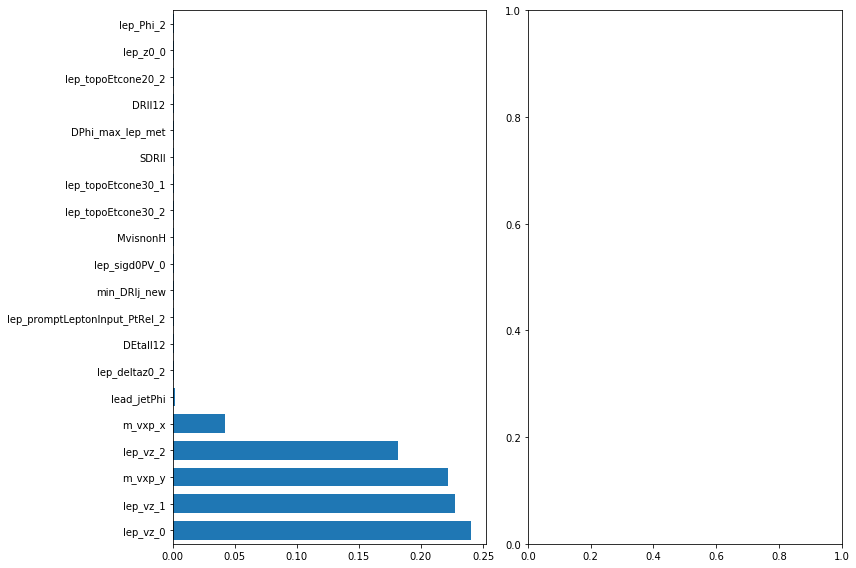

In [39]:
tree_importance_sorted_idx = np.flip(np.argsort(c_n2.feature_importances_))
tree_indices = np.arange(0, len(c_n2.feature_importances_)) + 0.5
#tree_indices = np.arange(0, 20)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         c_n2.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
#ax1.set_ylim((len(clf.feature_importances_)-20,len(clf.feature_importances_)))
ax1.set_ylim((0,20))
fig.tight_layout()
plt.show()

In [40]:
lst=X.columns[tree_importance_sorted_idx][:10]

In [41]:
lst2 = c_n2.feature_importances_[tree_importance_sorted_idx][:10]

In [42]:
df_m2 = pandas.DataFrame(list(zip(lst, lst2)),columns =['var', 'score'])

In [43]:
df_m2

,var,score
0,lep_vz_0,0.240619
1,lep_vz_1,0.227723
2,m_vxp_y,0.221728
3,lep_vz_2,0.181220
4,m_vxp_x,0.042296
5,lead_jetPhi,0.001602
6,lep_deltaz0_2,0.001120
7,DEtall12,0.001076
8,lep_promptLeptonInput_PtRel_2,0.001043
9,min_DRlj_new,0.001039


In [ ]:
Xnew2_s = StandardScaler().fit_transform(Xnew2) 

In [ ]:
Xnew2_s

In [ ]:
Xnew2_sdf=pandas.DataFrame(Xnew2_s, columns = Xnew2.columns)

In [ ]:
Xnew2_sdf.head()

In [ ]:
Xnew2.head()

In [ ]:
Xnew2['minOSMll'].sample(1,random_state=0).item()

In [ ]:
list_same_val_branch = []
for j in Xnew2.columns:
    i0=Xnew2[j].sample(1,random_state=0).item()
    #print(j,i0)
    if all(i ==i0 for i in Xnew2[j]):
        list_same_val_branch.append(j)
    #if i!=i0:
        

In [ ]:
list_same_val_branch

In [ ]:
Xnew3=Xnew2.drop(list_same_val_branch,axis=1)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [45]:
dim_in=len(X.columns)
dim_in

332

In [49]:
def base_model():
    model = Sequential()
    model.add(Dense(200, input_dim=dim_in, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    return model

In [50]:
krs_model = Sequential()
krs_model.add(Dense(units=64, activation='tanh', input_dim=dim_in))
krs_model.add(Dense(units=1, activation='sigmoid'))


In [51]:

krs_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [52]:
krs_model.output_shape
krs_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                21312     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,377
Trainable params: 21,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:

krs_model.fit(X, y, epochs=10, batch_size=100)

Epoch 1/10
  1700/125111 [..............................] - ETA: 31s - loss: 0.2665 - acc: 0.9641

In [48]:
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
